# Let us try doing some kind of Feature Engineering to reduce the total cost.

# 3. Feature Engineering

- From the above ML models on three different Imputation techniques, Random Forest with median imputation provides the least cost. Therefore we will perform feature engineering on train and test data with median imputation. We will also use Random Forest model, since it gave the best performance.

- For FE, we will use median imputation to fill the missing data and we will create new features called missing indicator, which creates new features where missing values are indicated as True and non missing values as False.

In [2]:
# loading the train and test dataset with missing indicator features.
train = pd.read_csv("Train_imputed_median")
test = pd.read_csv("test_imputed_median")
train_miss = pd.read_csv("train_miss_indi.csv")
test_miss = pd.read_csv("test_miss_indi.csv")
y_train = pd.read_csv("y_train")
y_test = pd.read_csv("y_test")

In [3]:
train.drop(['Unnamed: 0'],axis = 1,inplace = True)
test.drop(['Unnamed: 0'],axis = 1,inplace = True)
train_miss.drop(['Unnamed: 0'],axis = 1,inplace = True)
test_miss.drop(['Unnamed: 0'],axis = 1,inplace = True)
y_train.drop(['Unnamed: 0'],axis = 1,inplace = True)
y_test.drop(['Unnamed: 0'],axis = 1,inplace = True)

In [4]:
train['class'] = y_train

In [5]:
train[train_miss.columns] = train_miss
test[test_miss.columns] = test_miss


In [6]:
# Downsampling the negative class
train_neg_sampled = train[train['class'] == 0].sample(n = 10000,random_state = 42)
train_Sampled = train[train['class'] == 1].append(train_neg_sampled)

In [7]:
print("Shape of the train data after under sampling the negative class", train_Sampled.shape[0])

Shape of the train data after under sampling the negative class 11000


In [8]:
train_Sampled.head(3)

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,149,150,151,152,153,154,155,156,157,158
9,153204.0,182.0,126.0,0.0,0.0,0.0,0.0,0.0,11804.0,684444.0,...,False,False,False,False,False,False,False,False,False,False
23,453236.0,2926.0,126.0,0.0,0.0,0.0,0.0,222.0,323436.0,2999280.0,...,False,False,False,False,False,False,False,False,False,False
60,72504.0,1594.0,1052.0,0.0,0.0,0.0,244.0,178226.0,1249396.0,3813464.0,...,False,False,False,False,False,False,False,False,False,False


- columns from 0 to 158 are the missing indicator features. Where False is basically indicating the non missing values and true indicates the missing values. missing values can also be treated as features.

In [9]:
y_train = train_Sampled['class']
train_Sampled.drop(['class'],axis = 1, inplace= True)

In [10]:
#Upsampling the positive class
sm = over_sampling.SMOTE(ratio= 1.0)
train_Sampled_Smote, y_train = sm.fit_sample(train_Sampled,y_train)

In [11]:
print("Shape of train data after upsampling the positive class by smote", train_Sampled_Smote.shape)

Shape of train data after upsampling the positive class by smote (20000, 319)


In [12]:
# Standardizing the train and test data
std = StandardScaler()
train_std = std.fit_transform(train_Sampled_Smote)
test_std = std.transform(test)


# 3.1 Random Forest

In [18]:
# model fitting and hyperparameter tuning using gridsearch
x_cfl=RandomForestClassifier()
#weights = np.linspace(0.05, 0.95, 20)
prams={
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10]#,'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    
    
}
model=GridSearchCV(x_cfl,param_grid=prams,verbose=10,n_jobs=-1,scoring='f1',cv=5)
model.fit(train_std,y_train)
print("Best estimator is", model.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:  5.3min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:  7.6min remaining:   46.7s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  8.3min finished


Best estimator is {'max_depth': 10, 'n_estimators': 100}


In [19]:
# model fitting with best parameters
clf = RandomForestClassifier(n_estimators= 100 , max_depth=10)
clf.fit(train_std,y_train)
y_pred = clf.predict(test_std)
con_mat =confusion_matrix (y_test, y_pred)
print("-"*117)
print('Confusion Matrix: ', '\n',con_mat)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Confusion Matrix:  
 [[15199   426]
 [   16   359]]
---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  426
Type 2 error (False Negative) =  16
---------------------------------------------------------------------------------------------------------------------
Total cost =  12260
---------------------------------------------------------------------------------------------------------------------


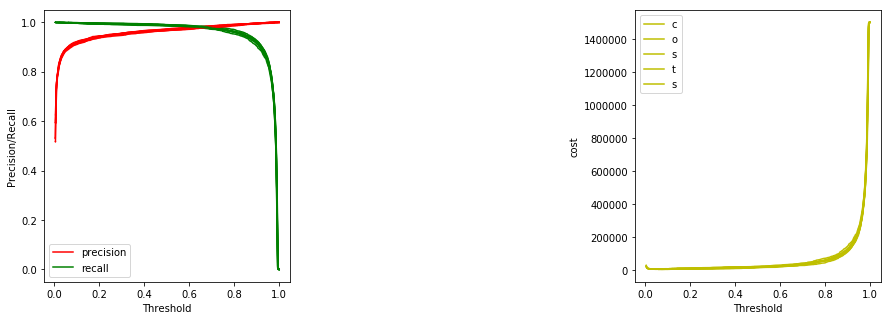

In [20]:
# CV to determine the best threshold
trail = 10
plot = []
for x in range(0,trail):
    train, test, y_tr, y_ts = train_test_split(train_std, y_train, stratify = y_train, train_size = 0.7)
    clf.fit(train,y_tr)
    pred = clf.predict_proba(test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_ts, pred)
    thresholds = np.append(thresholds,1)
      
    costs = []
    for threshold in thresholds:
        y_pred_thres = pred > threshold
        c = confusion_matrix(y_ts,y_pred_thres)
        cost = c[0,1] * 10 + c[1,0] * 500
        costs.append(cost)
        
    plot.append({'threshold': thresholds, 'precision':precision,'recall': recall, 'costs':costs})
    

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for x in plot:
    plt.plot(x['threshold'],x['precision'],'r')
    plt.plot(x['threshold'],x['recall'],'g')
    
plt.legend(('precision','recall'))
plt.xlabel('Threshold')
plt.ylabel("Precision/Recall")

plt.subplot(1,3,3)
for x in plot:
    plt.plot(x['threshold'],x['costs'],'y')
plt.legend(('costs'))
plt.xlabel('Threshold')
plt.ylabel("cost")
plt.show()

- At 0.2, we observe that precision is almost more than 95% and recall is almost around 98%. We want our recall to be near to 100% and at the same time we also want our precision to be high. 

In [22]:
clf.fit(train_std,y_train)
y_pred_prob = clf.predict_proba(test_std)[:,1]  > 0.20
con_mat =confusion_matrix (y_test, y_pred_prob)
print("-"*117)
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("-"*117)
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("-"*117)

---------------------------------------------------------------------------------------------------------------------
Type 1 error (False Positive) =  892
Type 2 error (False Negative) =  3
---------------------------------------------------------------------------------------------------------------------
Total cost =  10420
---------------------------------------------------------------------------------------------------------------------
